# Tools

In [150]:
import pandas as pd

In [151]:
from IPython.display import display

In [152]:
from pandas.plotting import table

In [153]:
import matplotlib.pyplot as plt

In [154]:
import numpy as np

In [155]:
from matplotlib import cm

In [156]:
from itertools import combinations

In [157]:
from matplotlib import colormaps

In [158]:
import networkx as nx

In [159]:
import matplotlib.pyplot as plt

In [160]:
import plotly.graph_objects as go

In [161]:
import seaborn as sns

In [162]:
import textwrap

# Analysis MRV topics

### 0 Data preparation

#### 0.1 Import files

In [163]:
df = pd.read_excel("MRVdata_0810.xlsx")
pd.options.display.max_columns = None
#display(df)
#code above: shows excel table

In [164]:
# read excel file with continent data 
continent_data = pd.read_excel('continents.xlsx')

#### 0.2 Exclusion of data

In [165]:
# filter data frame to exclude studies from 2024
df_filtered = df[df['Year'] != 2024]

In [166]:
df_included = df_filtered[df_filtered['Inclusion/exclusion'] == 'Inclusion'] # new dataframe defined to exclude studies without access or excluded papers
#controll new data frame
#df_included['Inclusion/exclusion'].value_counts()

#### 0.3 Change study location to continent

In [167]:
# create a dictionary for the assignment of countries to continents
country_to_continent = dict(zip(continent_data['Country'], continent_data['Continent']))

# Function to determine the continent based on the country
def get_continent(study_location, continent_column): #part of the function, not column names of the df; will be defined later when function is applied
    if pd.isna(study_location):
        return "Not specified"
    if study_location == "Multiple countries":
        return continent_column  # uses the manually definied continents for the category "Multiple countries"
    return country_to_continent.get(study_location.strip(), "Not specified")  # Search for the country in the dictionary and return the continent or 'not specified'

# avoid warning
df_included = df_included.copy()

# apply function to df_included
df_included['Study location_continent'] = df_included.apply(
    lambda row: get_continent(row['Study location'], row['Study location: Continent']),
    axis=1
)

#pd.options.display.max_columns = None
#display(df_included)

#### 0.4 Group CDR method and color scheme

In [168]:
#columns with all CDR methods
CDR_columns = ['BECCS', 'General forestry', 'A/R', 'Agroforestry', 'Forest management', 'DACCS', 'EW', 'OAE', 'OIF/AU', 'Biochar', 'SCS', 'Blue carbon', 'Restoration of landscapes and peats', 'CCUS', 'Other', 'General CDR', 'DOC', 'Algae ', 'CCS']

In [169]:
# Define the custom color scheme for each CDR method
custom_colors_CDR_method = {
    'BECCS': '#f4d6ae', 'General forestry': '#bcbd22', 'A/R': '#aab792', 
    'Agroforestry': '#e9ede2', 'Forest management': '#d2bfac', 'DACCS': '#dd7500',
    'EW': '#d6b8c1', 'OAE': '#ecf1f9', 'OIF/AU': '#709fca', 'Biochar': '#b7768bff',
    'SCS': '#769112', 'Blue carbon': '#d8e3f1', 'Restoration of landscapes and peats': '#d3dbc7',
    'CCUS': '#b55d00', 'Other': '#e5e5e5', 'General CDR': '#e5b138', 'DOC': '#17becf',
    'Algae ': '#2ca02c', 'CCS': '#d62728'
}

#### 0.5 Group MRV topics and color scheme

In [170]:
#columns with all MRV topics
MRV_columns = ['General MRV', 'Quantification', 'Monitoring', 'Quality', 'Governance', 'Reporting', 'Verification', 'External impacts']

In [171]:
# Define the new custom color scheme for MRV topics
mrv_topic_colors = {
    'General MRV': '#e5b138',      # muted yellow
    'Quantification': '#7da7b8',   # darker bluish-grey
    'Monitoring': '#8dc39f',        # stronger soft green
    'Quality': '#c76a85',           # berry red
    'Governance': '#b39bc8',        # stronger lavender
    'Reporting': '#e1a6b8',         # stronger soft pink
    'Verification': '#a8a8a8',      # medium grey
    'External impacts': '#d0c97b'   # stronger soft yellow
}

#### 0.6 Dataset explosion

In [172]:
#add new column for CDR method and study focus in the dataset
def extract_CDR_method_focus(row):
    CDR_method = []
    CDR_focus = []
    
    for column in CDR_columns:  # previously defined list with columns that contain CDR methods
        if row[column] > 0:
            CDR_method.append(column)
            CDR_focus.append(row[column])
    
    return pd.Series([CDR_method, CDR_focus])

# new copy of the data set to avoid warning
df_included = df_included.copy()

# add new columns to the data frame
df_included['CDR_method'] = df_included.apply(lambda row: extract_CDR_method_focus(row)[0], axis=1)
df_included['CDR_focus'] = df_included.apply(lambda row: extract_CDR_method_focus(row)[1], axis=1)

#display dataset to see if newly added columns are correct
#pd.options.display.max_columns = None
#display(df_included)

In [173]:
#add new column for MRV topic and study focus to the dataset
def extract_MRV_topic_focus(row):
    MRV_topic = []
    MRV_focus = []
    
    for column in MRV_columns:  # previously defined list with columns that contain MRV topics
        if row[column] > 0:
            MRV_topic.append(column)
            MRV_focus.append(row[column])
    
    return pd.Series([MRV_topic, MRV_focus])

# new copy of the data set to avoid warning
df_included = df_included.copy()

# add new columns to the data frame
df_included['MRV_topic'] = df_included.apply(lambda row: extract_MRV_topic_focus(row)[0], axis=1)
df_included['MRV_focus'] = df_included.apply(lambda row: extract_MRV_topic_focus(row)[1], axis=1)

#display dataset to see if newly added columns are correct
#pd.options.display.max_columns = None
#display(df_included)

In [174]:
# explode CDR method and focus
df_CDRexplode = df_included.explode(['CDR_method', 'CDR_focus'])

# explode MRV topic and focus
df_exploded = df_CDRexplode.explode(['MRV_topic', 'MRV_focus'])

# every CDR method and every MRV topic is in one line (in combination with study focus)

#display dataset to see if newly added columns are correct
#pd.options.display.max_columns = None
#display(df_exploded)

#### 0.7 Definition CDR groups & color scheme

In [175]:
# Group CDR Methods to marine, terrestrial, and CCS technologies. Keep A/R and SCS as individual technologies
cdr_group_mapping = {
     # Marine CDR group
    "OIF/AU":"Marine CDR",
    "Blue carbon": "Marine CDR",
    "OAE": "Marine CDR",
    "DOC": "Marine CDR",
    "Algae ": "Marine CDR",
    
    # Terrestrial CDR group
    "EW": "Terrestrial CDR",
    "Biochar": "Terrestrial CDR",
    "Restoration of landscapes and peats": "Terrestrial CDR",
    
    # CCS group
    "DACCS": "CCS",
    "BECCS": "CCS",
    "CCUS": "CCS",
    "CCS": "CCS",
    
    # General CDR/Other group
    "General CDR": "General CDR/Other",
    "Other": "General CDR/Other",

    # SCS
    "SCS": "SCS",

    # Forestry
    "General forestry": "Forestry",
    "A/R": "Forestry",
    "Agroforestry": "Forestry",
    "Forest management": "Forestry",
}
# Create a new column ‘CDR_group’ in df_exploded based on the ‘CDR_method’ column
df_exploded['CDR_group'] = df_exploded['CDR_method'].map(cdr_group_mapping)

# Display the updated DataFrame
#pd.options.display.max_columns = None  # Show all columns
#display(df_exploded)

In [176]:
# Define the custom color scheme for each CDR group
cdr_group_colors = {
    "Marine CDR": '#7eaed3',    # bluew for Marine CDR
    "Terrestrial CDR": '#b2df8a',  # green for Terrestrial CDR
    "CCS": '#ff7f00',            # orange for CCS
    "General CDR/Other": '#e5e5e5', # grey for General/Other
    "SCS": '#C1A28A' ,            # brown for SCS
    "Forestry": '#8fbc8f'         # green for Forestry
}


### 1 Exploded dataset: CDR method & MRV topic

#### Figure 1: MRV topics per CDR method

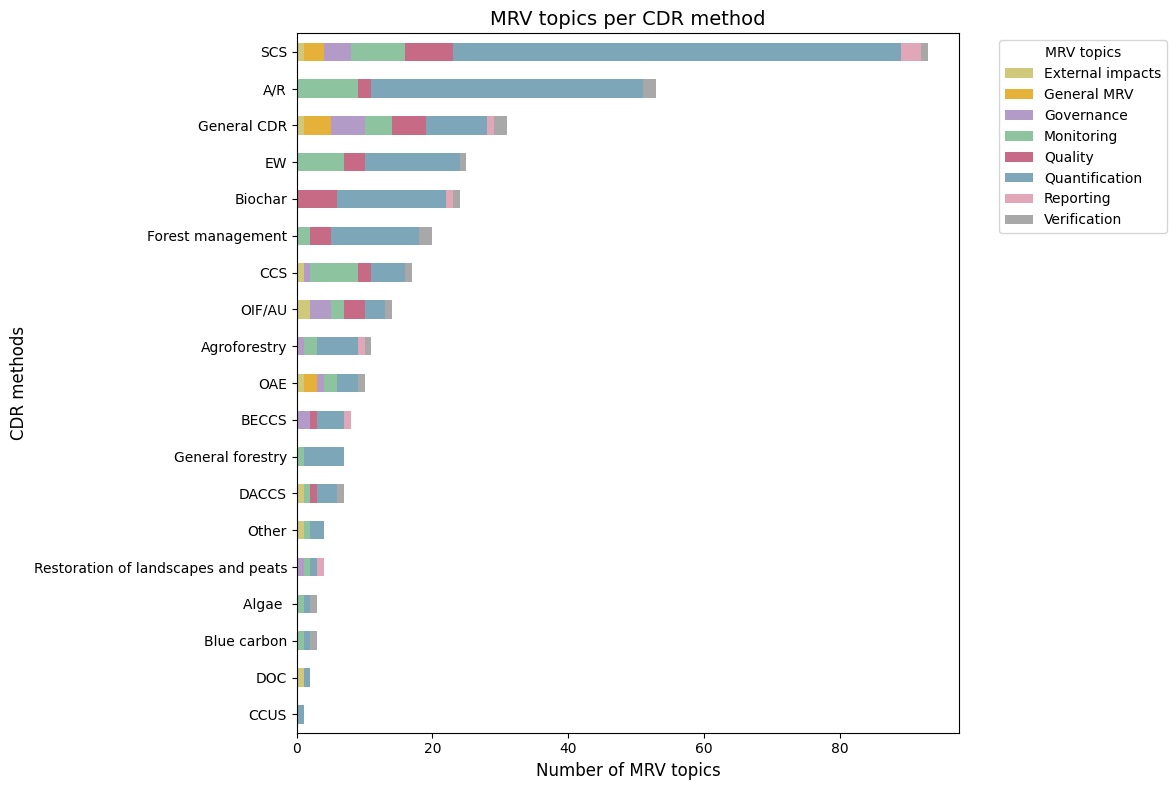

In [177]:
# group data for CDR method and MRV topic
grouped_data = df_exploded.groupby(['CDR_method', 'MRV_topic'], observed=False).size().reset_index(name='Count')

# pivot tables
pivot_table = grouped_data.pivot(index='CDR_method', columns='MRV_topic', values='Count').fillna(0)

# sum MRV topics per CDR method and sort data 
pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='Total', ascending=True)  # sort for total sum
pivot_table = pivot_table.drop(columns='Total')  # remove column total sum

# Get colors for each MRV topic based on the new color scheme
mrv_topics = pivot_table.columns
colors_MRV = [mrv_topic_colors.get(topic, '#cccccc') for topic in mrv_topics]  # Default to grey if topic not in mrv_topic_colors

# stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
pivot_table.plot(kind='barh', stacked=True, ax=ax, color = colors_MRV)  # 'barh' for horizontal bars
plt.title('MRV topics per CDR method', fontsize=14)
plt.xlabel('Number of MRV topics', fontsize=12)
plt.ylabel('CDR methods', fontsize=12)
plt.yticks(rotation=0)

# legend
plt.legend(title='MRV topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()

#### Figure 2: MRV topics per CDR group

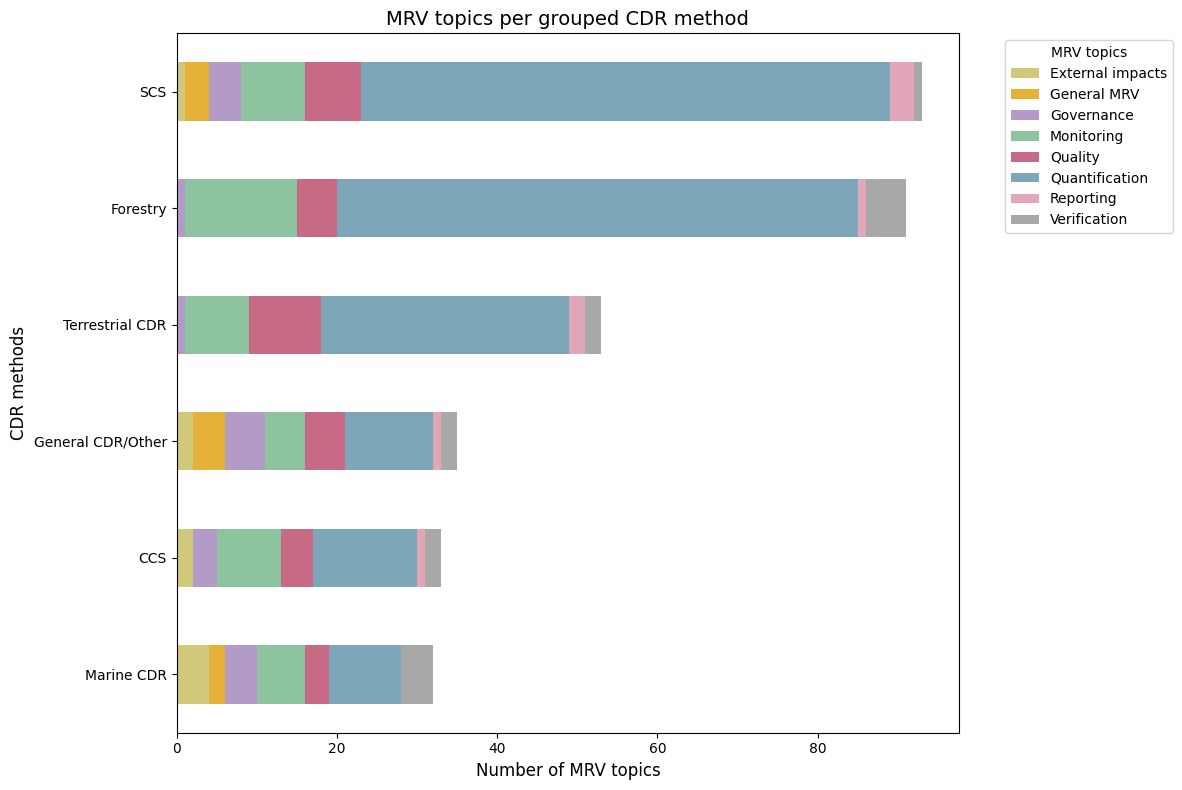

In [178]:
# group data for CDR method and MRV topic
grouped_data = df_exploded.groupby(['CDR_group', 'MRV_topic']).size().reset_index(name='Count')

# pivot tables
pivot_table = grouped_data.pivot(index='CDR_group', columns='MRV_topic', values='Count').fillna(0)

# sum MRV topics per CDR group and sort data 
pivot_table['Total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='Total', ascending=True)  # sort for total sum
pivot_table = pivot_table.drop(columns='Total')  # remove column totoal sum

# Get colors for each MRV topic based on the new color scheme
mrv_topics = pivot_table.columns
colors_MRV = [mrv_topic_colors.get(topic, '#cccccc') for topic in mrv_topics]  # Default to grey if topic not in mrv_topic_colors

# stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
pivot_table.plot(kind='barh', stacked=True, ax=ax, color = colors_MRV)  # 'barh' for horizontal bars
plt.title('MRV topics per grouped CDR method', fontsize=14)
plt.xlabel('Number of MRV topics', fontsize=12)
plt.ylabel('CDR methods', fontsize=12)
plt.yticks(rotation=0)

# legend
plt.legend(title='MRV topics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()

### 2 Exploded datset: MRV topics and different foci per CDR method

#### 2.1 MRV topics with main focus per CDR method

In [179]:
# count MRV main topics
main_topics = df_exploded[df_exploded['MRV_focus'] == 1].groupby(['CDR_method', 'MRV_topic']).size().reset_index(name='Main_Topic_Count')

# create pivot table for MRV main topics per CDR method
main_topics_pivot = main_topics.pivot(index='CDR_method', columns='MRV_topic', values='Main_Topic_Count').fillna(0)

# Reset index to bring 'CDR_method' back as a column
main_topics_pivot_reset = main_topics_pivot.reset_index()

# Rename 'CDR_method' column to 'CDR methods'
main_topics_pivot_reset.rename(columns={'CDR_method': 'CDR method'}, inplace=True)

# Sort columns by sum of Main_Topic_Count
maintopic_sorted = main_topics_pivot.sum().sort_values(ascending=False)

# Create a sorted column list (keeping 'CDR_method' at the front)
sorted_columns_m = ['CDR method'] + maintopic_sorted.index.tolist()

# Select and sort the columns in the final table
sorted_maintopic_table = main_topics_pivot_reset[sorted_columns_m]

# show final table
# pd.options.display.max_columns = None  # show all columns
# print(sorted_maintopic_table)

#### Figure 3: Overview table

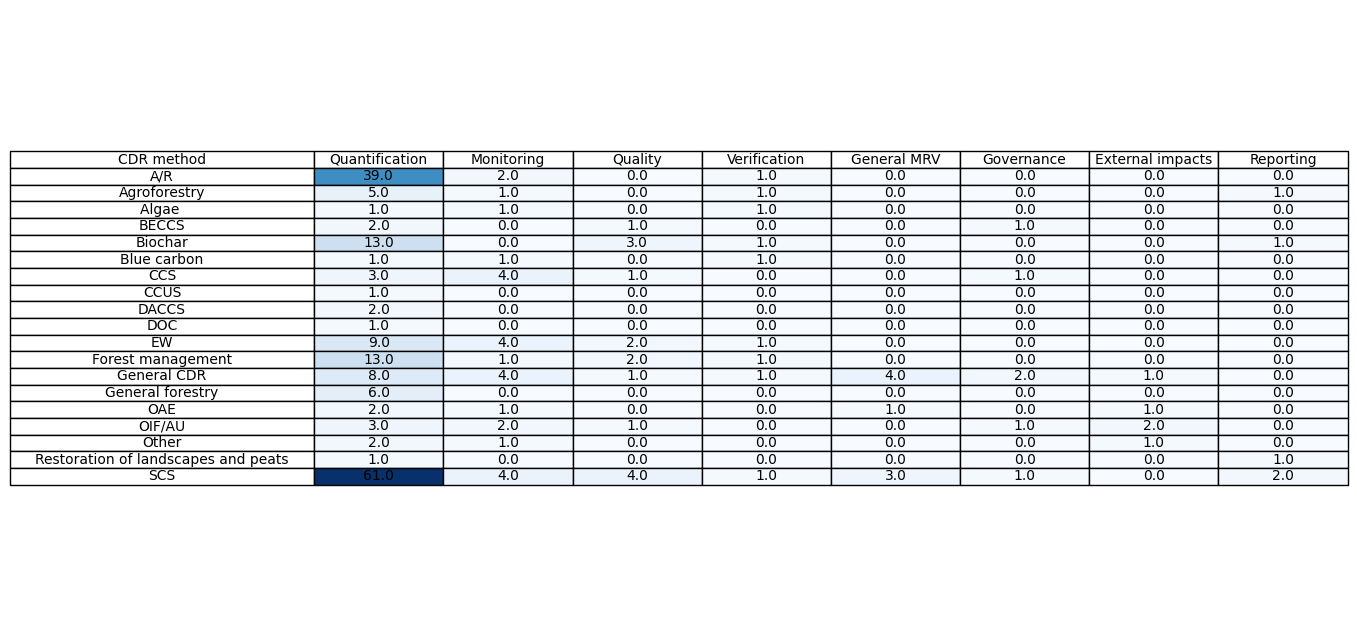

In [180]:
# colozize the columns
def colorize_table(table_plot, dataframe, cmap_name='Blues'):
    numeric_df = dataframe.select_dtypes(include=[np.number])  # Only numeric values
    cmap = colormaps.get_cmap(cmap_name)  # use a color map
    norm = plt.Normalize(vmin=numeric_df.min().min(), vmax=numeric_df.max().max())  # normalization of values

    for i in range(len(dataframe)):
        for j in range(1, len(dataframe.columns)):  # do not color column 1 (CDR methods)
            if dataframe.columns[j] in numeric_df.columns:  # Only numeric values
                cell_value = dataframe.iloc[i, j]
                color = cmap(norm(cell_value))
                table_plot[(i+1, j)].set_facecolor(color)

# Create a figure and axes for the table
fig, ax = plt.subplots(figsize=(15, 8))

# remove axes
ax.axis('off')

# leave the index for CDR methods out
table_plot = ax.table(cellText=sorted_maintopic_table.values,
                      colLabels=sorted_maintopic_table.columns,
                      cellLoc='center',
                      colLoc='center',
                      loc='center')

# Adjust the column width
table_plot.auto_set_column_width([0])
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(10)


colorize_table(table_plot, sorted_maintopic_table, cmap_name='Blues')
plt.show()

#### 2.2 MRV topics with side focus

In [181]:
# count MRV side topics
side_topics = df_exploded[df_exploded['MRV_focus'] == 2].groupby(['CDR_method', 'MRV_topic']).size().reset_index(name='Side_Topic_Count')

# create pivot table for MRV side topics per CDR method
side_topics_pivot = side_topics.pivot(index='CDR_method', columns='MRV_topic', values='Side_Topic_Count').fillna(0)

# Reset index to bring 'CDR_method' back as a column
side_topics_pivot_reset = side_topics_pivot.reset_index()

# Rename 'CDR_method' column to 'CDR methods'
side_topics_pivot_reset.rename(columns={'CDR_method': 'CDR method'}, inplace=True)

# Sort columns by sum of Side_Topic_Count
sidetopic_sorted = side_topics_pivot_reset.iloc[:, 1:].sum().sort_values(ascending=False)

# Create a sorted column list (keeping 'CDR methods' at the front)
sorted_columns_s = ['CDR method'] + sidetopic_sorted.index.tolist()

# Select and sort the columns in the final table
sorted_sidetopic_table = side_topics_pivot_reset[sorted_columns_s]

# Show final table
#pd.options.display.max_columns = None  # Show all columns
#print(sorted_sidetopic_table)

#### Figure 4: Overview table 

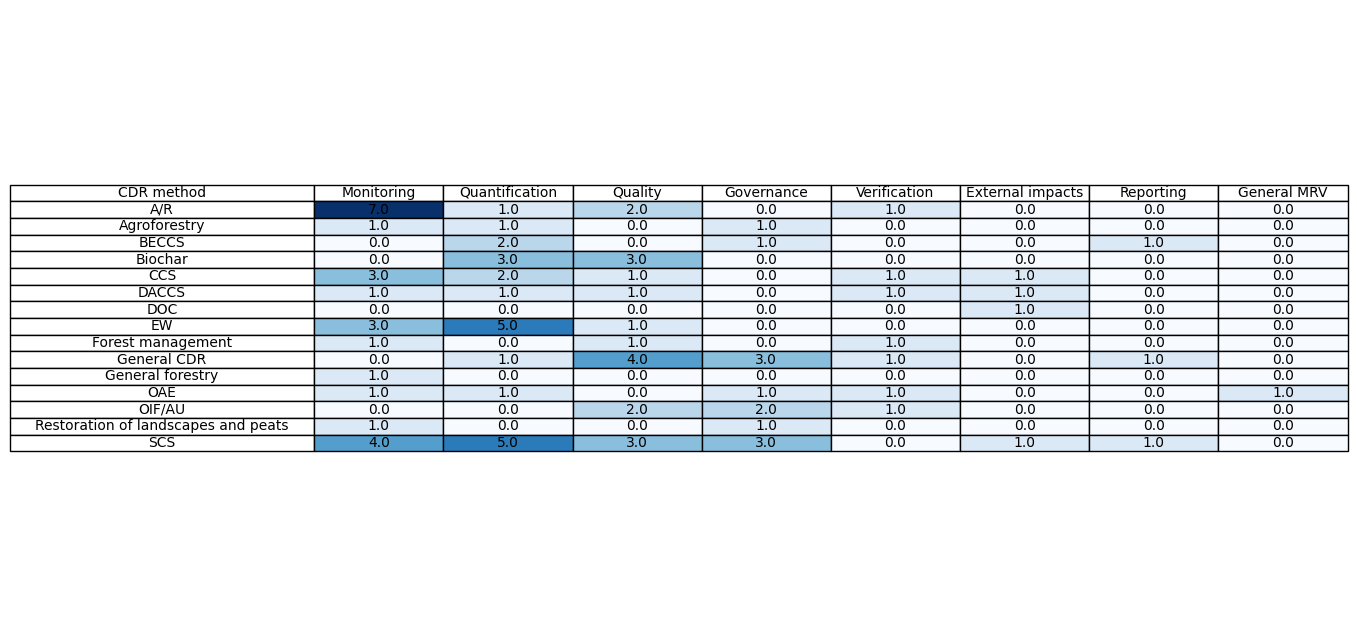

In [182]:
# colozize the columns
def colorize_table(table_plot, dataframe, cmap_name='Blues'):
    numeric_df = dataframe.select_dtypes(include=[np.number])  # Only numeric values
    cmap = colormaps.get_cmap(cmap_name)  # use a color map
    norm = plt.Normalize(vmin=numeric_df.min().min(), vmax=numeric_df.max().max())  # normalization of values

    for i in range(len(dataframe)):
        for j in range(1, len(dataframe.columns)):  # do not color column 1 (CDR methods)
            if dataframe.columns[j] in numeric_df.columns:  # Only numeric values
                cell_value = dataframe.iloc[i, j]
                color = cmap(norm(cell_value))
                table_plot[(i+1, j)].set_facecolor(color)

# Create a figure and axes for the table
fig, ax = plt.subplots(figsize=(15, 8))

# remove axes
ax.axis('off')

# leave the index for CDR methods out
table_plot = ax.table(cellText=sorted_sidetopic_table.values, #includes table that is displayed
                      colLabels=sorted_sidetopic_table.columns,
                      cellLoc='center',
                      colLoc='center',
                      loc='center')

# Adjust the column width
table_plot.auto_set_column_width([0])
table_plot.auto_set_font_size(False)
table_plot.set_fontsize(10)


colorize_table(table_plot, sorted_sidetopic_table, cmap_name='Blues') #define table

plt.show()

In [183]:
# learning from these results: combine some of the CDR methods and focus on Quantification as main MRV topic

#### 2.3 Overview of MRV topics and foci

#### Figure 5: Stacked bar plot MRV topic by focus

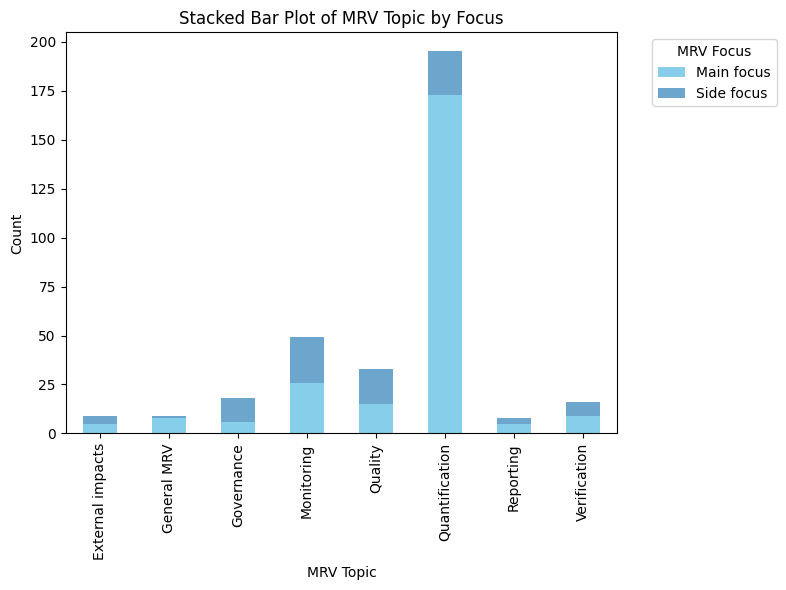

In [184]:
# Get the counts of each CDR_focus per CDR_method
df_counts = df_exploded.groupby(['MRV_topic', 'MRV_focus']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Stacked bar plot
df_counts.plot(kind='bar', stacked=True, ax=ax, color=['#87CEEB', '#6CA6CD'])

# Customizing plot
ax.set_xlabel('MRV Topic')
ax.set_ylabel('Count')
ax.set_title('Stacked Bar Plot of MRV Topic by Focus')
plt.xticks(rotation=90)
legend_mrvfocus = ['Main focus', 'Side focus']
plt.legend(legend_mrvfocus, title='MRV Focus', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()
plt.show()

### 3 MRV topic & study location

#### Figure 6: Bar chart MRV topics per continent

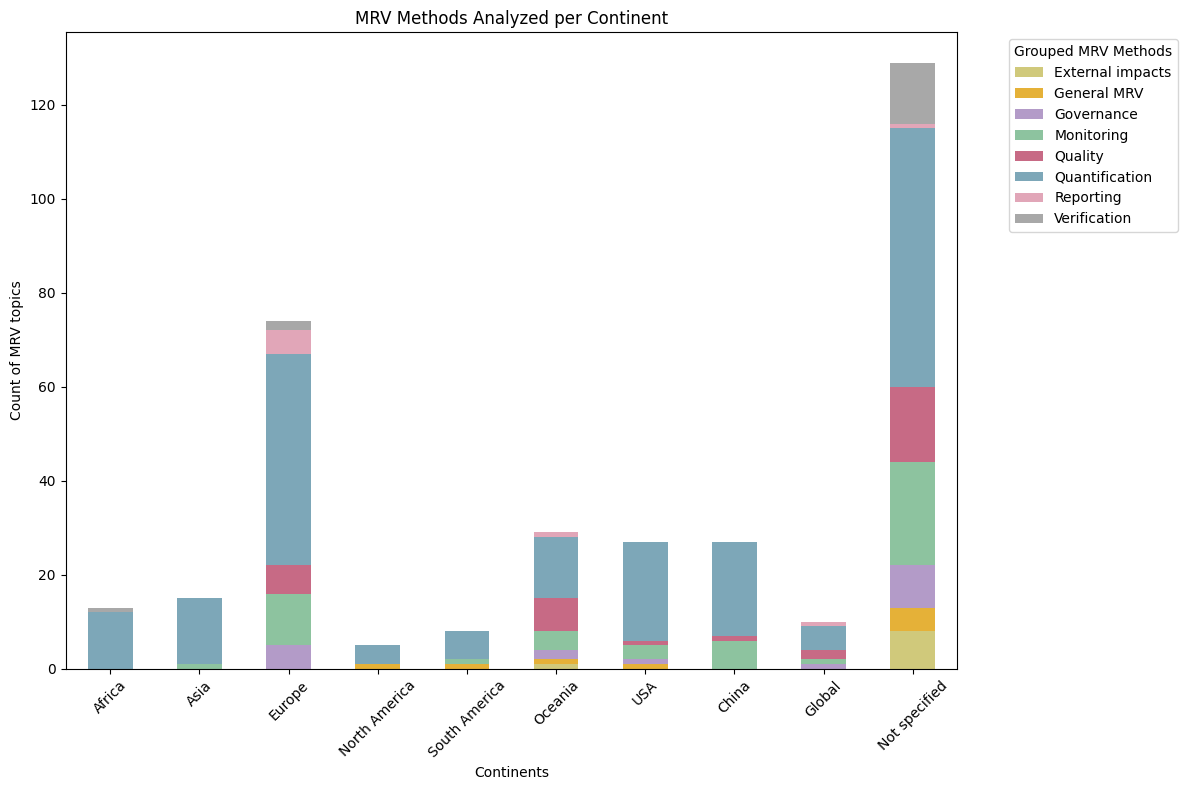

In [185]:
# Set the order of continents to be shown on the x-axis
desired_order = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania', 'USA', 'China', 'Global', 'Not specified']  

# Convert the Study location_continent column to a categorical type with the specified order
df_exploded['Study location_continent'] = pd.Categorical(
    df_exploded['Study location_continent'],
    categories=desired_order,
    ordered=True
)

# Group by continent and CDR method, and count occurrences
continent_method_counts = df_exploded.groupby(['Study location_continent', 'MRV_topic'], observed=False).size().reset_index(name='Count')

# Pivot the data for the stacked bar plot
pivot_data = continent_method_counts.pivot(index='Study location_continent', columns='MRV_topic', values='Count').fillna(0)

# Create a stacked bar plot
pivot_data.plot(kind='bar', stacked=True, figsize=(12, 8), color=colors_MRV)  # Use the colors_MRV for the plot

plt.title("MRV Methods Analyzed per Continent")
plt.xlabel("Continents")
plt.ylabel("Count of MRV topics")
plt.xticks(rotation=45)
plt.legend(title="Grouped MRV Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 4 Which MRV Topics are analyzed together?

#### 4.1 Data preparation

In [186]:
# Group by 'Publication ID' and aggregate the unique CDR methods per publication
grouped = df_exploded.groupby('Publication ID')['MRV_topic'].unique()

# Create pairs of CDR methods for each publication, including both directions
pairs = []

for methods in grouped:
    # Create all possible combinations of CDR methods within each publication
    for combo in combinations(methods, 2):
        # Add both directions of the pair
        pairs.append(combo)  # Method 1 -> Method 2
        pairs.append(combo[::-1])  # Method 2 -> Method 1 (reverse)

# Create a DataFrame of pairs and count the occurrences
pair_counts_MRV = pd.DataFrame(pairs, columns=['Topic 1', 'Topic 2']).value_counts().reset_index(name='Count')

# Display the results
#print(pair_counts_MRV)

#### Figure 7: Network Graph for MRV topics

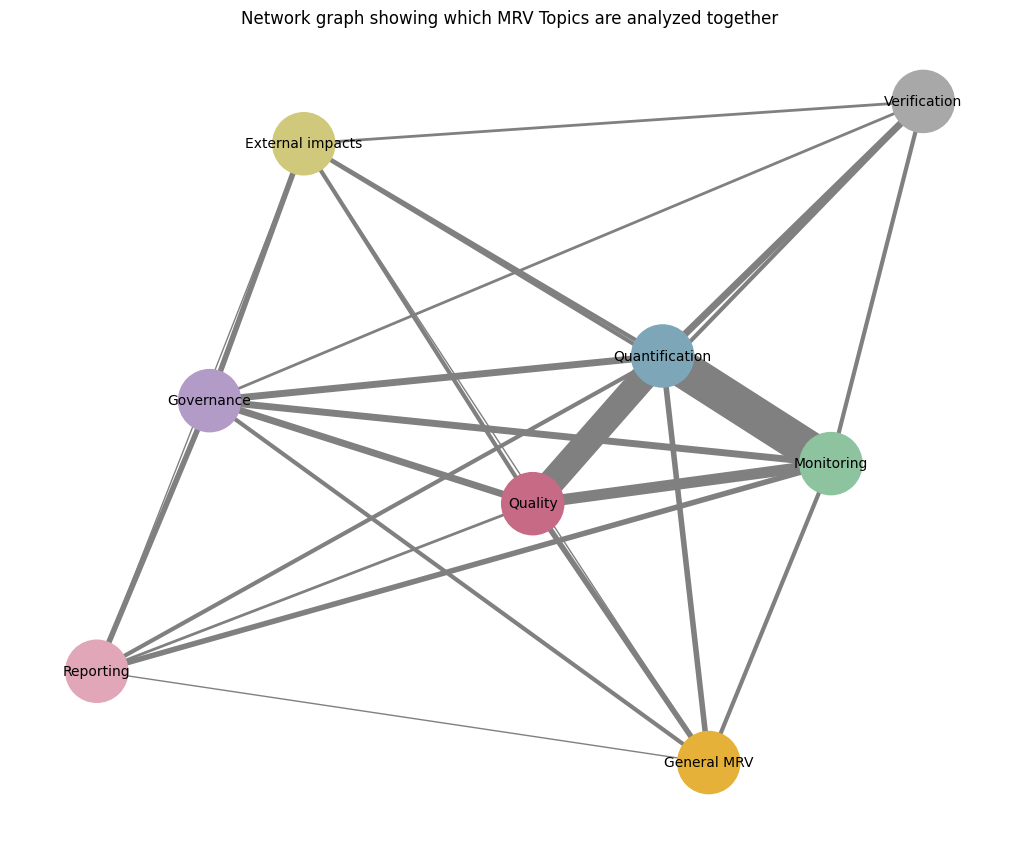

In [187]:
# Create a graph from the pair counts
G = nx.Graph()

# Add edges to the graph, with the weight being the count of co-occurrence
for _, row in pair_counts_MRV.iterrows():
    G.add_edge(row['Topic 1'], row['Topic 2'], weight=row['Count'])

# Extract node colors based on the color scheme
node_colors = [mrv_topic_colors.get(node, 'skyblue') for node in G.nodes]  # Default to 'skyblue' if the method is not found

# Plot the network graph
plt.figure(figsize=(10, 8))

# Use edge weights to adjust the width of the edges
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

# Draw the graph with nodes, edges, and labels
pos = nx.spring_layout(G, k=0.5, seed=42)  # Positioning the nodes
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=2000, font_size=10, edge_color='gray', width=weights)

plt.title("Network graph showing which MRV Topics are analyzed together")
plt.show()

#### Figure 8: Heatmap for MRV methods

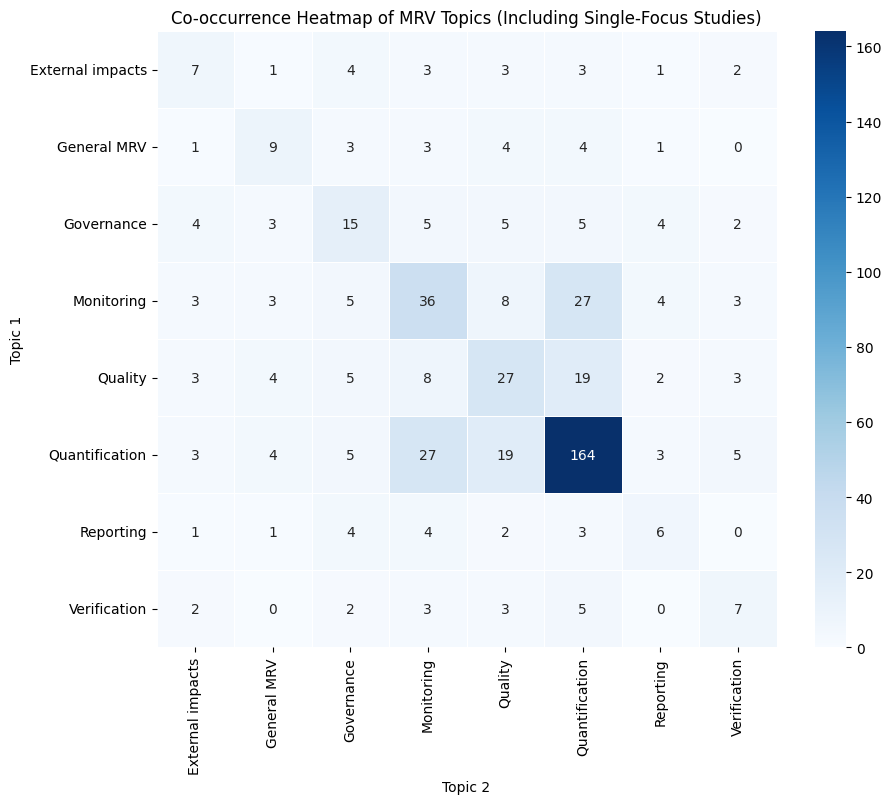

In [188]:
# Group by 'Publication ID' and count the number of unique MRV topics for each publication
grouped_mrv = df_exploded.groupby('Publication ID')['MRV_topic'].unique()

# Calculate the number of publications that focus on only one MRV topic
single_focus_counts = grouped_mrv.explode().value_counts()

# Initialize the matrix of MRV co-occurrences (including both directions)
pairs = []

for topics in grouped_mrv:
    for combo in combinations(topics, 2):
        # Add both directions of the pair (MRV topic 1 -> MRV topic 2, and vice versa)
        pairs.append(combo)
        pairs.append(combo[::-1])

# Create a DataFrame of pairs and count the occurrences
pair_counts_MRV = pd.DataFrame(pairs, columns=['Topic 1', 'Topic 2']).value_counts().reset_index(name='Count')

# Pivot the data to create a matrix of MRV co-occurrences
heatmap_data = pair_counts_MRV.pivot(index='Topic 1', columns='Topic 2', values='Count').fillna(0)

# Fill the diagonal with the number of studies focusing on a single MRV topic
for topic in heatmap_data.index:
    heatmap_data.loc[topic, topic] = single_focus_counts.get(topic, 0)

# Create a heatmap with standard integer formatting for annotations
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", linewidths=.5, fmt='g')  # 'g' for general number format

plt.title("Co-occurrence Heatmap of MRV Topics (Including Single-Focus Studies)")
plt.show()

#### 4. 2 Heatmap of MRV topics considering the focus levels

In [189]:
# Convert the CDR_focus column to integers, converting non-numeric values to NaN
df_exploded['MRV_focus'] = pd.to_numeric(df_exploded['MRV_focus'], errors='coerce').astype('Int64')

#### Figure 9:  Heatmap for MRV topics considering main and side focus

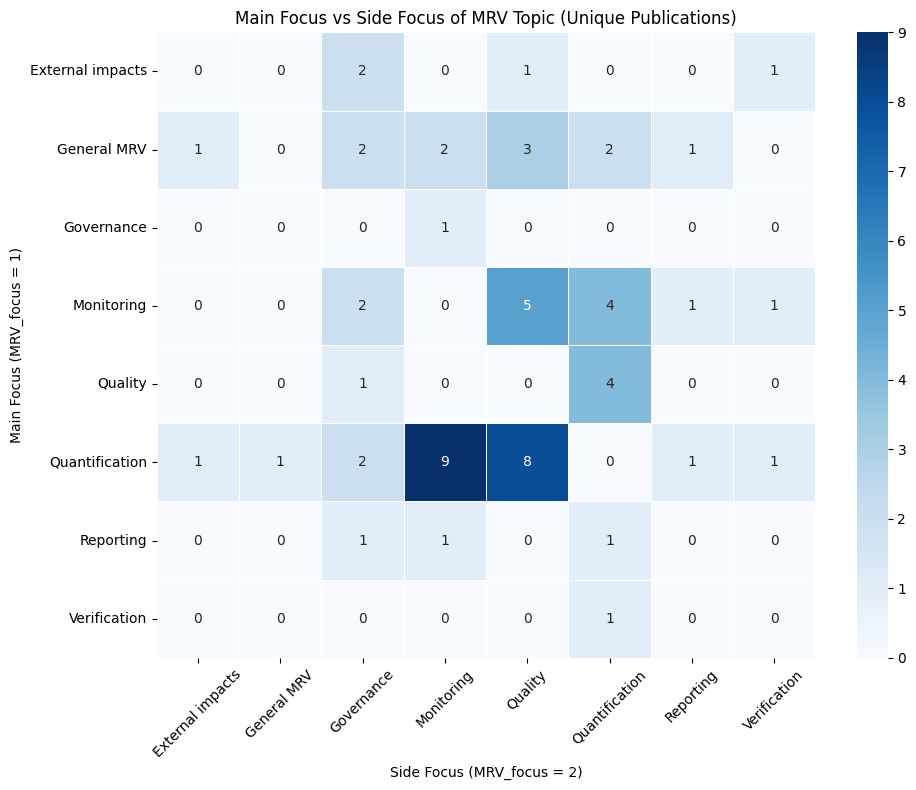

In [190]:
# Create separate DataFrames for main focus (CDR_focus = 1) and side focus (CDR_focus = 2)
main_focus_df_mrv = df_exploded[df_exploded['MRV_focus'] == 1][['Publication ID', 'MRV_topic']].rename(columns={'MRV_topic': 'MRV_topic_main'})
side_focus_df_mrv = df_exploded[df_exploded['MRV_focus'] == 2][['Publication ID', 'MRV_topic']].rename(columns={'MRV_topic': 'MRV_topic_side'})

# Merge the main and side focus DataFrames on 'Publication ID'
# This merge keeps only publications that have both a main focus and a side focus
merged_df = pd.merge(main_focus_df_mrv, side_focus_df_mrv, on='Publication ID')

# Remove duplicates to ensure each publication is only counted once
# Drop duplicate rows based on Publication ID and the CDR_method_main/CDR_method_side combination
deduped_df = merged_df.drop_duplicates(subset=['Publication ID', 'MRV_topic_main', 'MRV_topic_side'])

# Create the pivot table to show relationships between main and side focuses
# Index represents CDR_method_main (y-axis), columns represent CDR_method_side (x-axis)
pivot_table = deduped_df.pivot_table(index='MRV_topic_main', columns='MRV_topic_side', aggfunc='size', fill_value=0)

# Display the pivot table
#print("Pivot table with unique publications counted:\n", pivot_table)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="Blues", linewidths=.5)
plt.title("Main Focus vs Side Focus of MRV Topic (Unique Publications)")
plt.xlabel("Side Focus (MRV_focus = 2)")
plt.ylabel("Main Focus (MRV_focus = 1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5 MRV topic: Quality

In [191]:
# Define the columns
columns_MRV_quality = [
    "Durability: longevity", 
    "Durabilitiy: disturbance/reversal risks", 
    "Leakage: potential sources", 
    "Leakage: Detection", 
    "Leakage: Safeguards ", 
    "Additionality", 
    "sources of uncertainty", 
    "uncertainty management"
]

#### Figure 8: Quality topics per CDR method

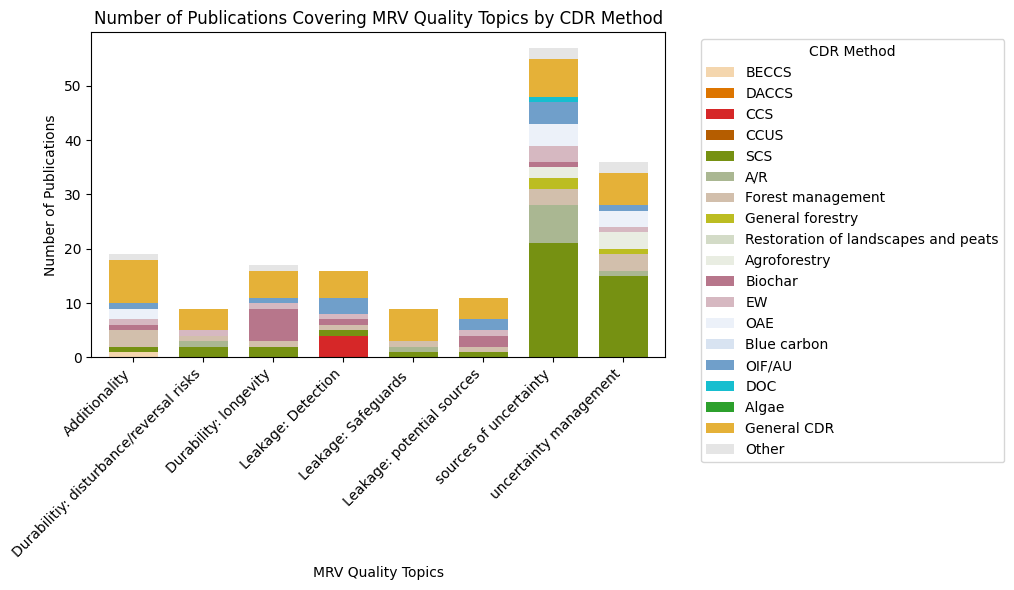

In [192]:
# Check if any rows in 'CDR_method' contain lists or non-string values and convert them to string
df_included['CDR_method'] = df_included['CDR_method'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Convert the columns to numeric
df_included[columns_MRV_quality] = df_included[columns_MRV_quality].apply(pd.to_numeric, errors='coerce')

# Define the order for CDR methods
# Set the order of CDR technologies to be shown in the bars
desired_order_CDR = ['BECCS', 'DACCS', 'CCS', 'CCUS','SCS', 'A/R', 'Forest management', 'General forestry', 
                     'Restoration of landscapes and peats', 'Agroforestry', 'Biochar', 'EW', 'OAE', 'Blue carbon', 'OIF/AU',
                     'DOC', 'Algae ', 'General CDR', 'Other']

# Set 'CDR_method' as a categorical type with the specified order
df_included['CDR_method'] = pd.Categorical(
    df_included['CDR_method'],
    categories=desired_order_CDR,
    ordered=True
)

# Melt the DataFrame to have 'CDR_method' and MRV quality topics in long format
melted_quality_df = df_included.melt(id_vars=['CDR_method'], value_vars=columns_MRV_quality, var_name='Topic', value_name='Value')

# Filter to keep only the rows where Value is 1 (indicating presence of the topic)
melted_quality_df = melted_quality_df[melted_quality_df['Value'] == 1]

# Count occurrences of each MRV topic per CDR method
count_quality_df = melted_quality_df.groupby(['Topic', 'CDR_method'], observed=False).size().unstack(fill_value=0)

# Create a stacked bar plot using the defined colors for each CDR method
count_quality_df.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.7, 
              color=[custom_colors_CDR_method.get(cdr, '#cccccc') for cdr in count_quality_df.columns])

# Add titles and labels
plt.title('Number of Publications Covering MRV Quality Topics by CDR Method')
plt.ylabel('Number of Publications')
plt.xlabel('MRV Quality Topics')
plt.xticks(rotation=45, ha='right')
plt.legend(title='CDR Method', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()

### 6 MRV topic: Monitoring (need to be fixed and tidied up)


##### Absolute numbers

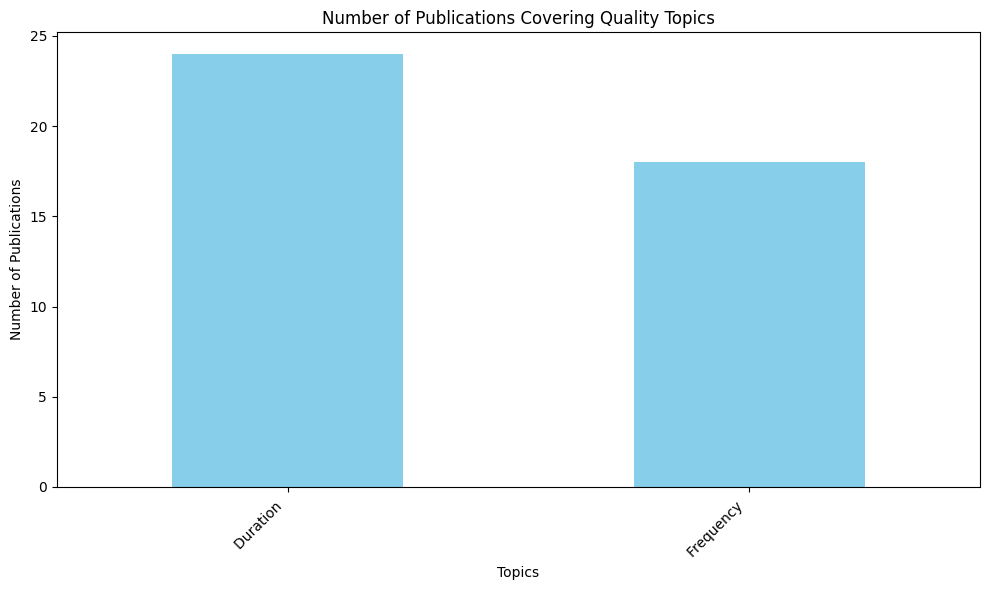

In [193]:
# Define the columns
columns_monitoring = ["Duration ", "Frequency "]

# Convert the columns to numeric 
df_included[columns_monitoring] = df_included[columns_monitoring].apply(pd.to_numeric, errors='coerce')

# Count how many publications mention each topic (sum the values for each column)
topic_monitoring = df_included[columns_monitoring].sum()

# Create a bar plot to visualize the counts
plt.figure(figsize=(10, 6))
topic_monitoring.plot(kind='bar', color='skyblue')
plt.title('Number of Publications Covering Quality Topics')
plt.ylabel('Number of Publications')
plt.xlabel('Topics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Absolute numbers by CDR technology

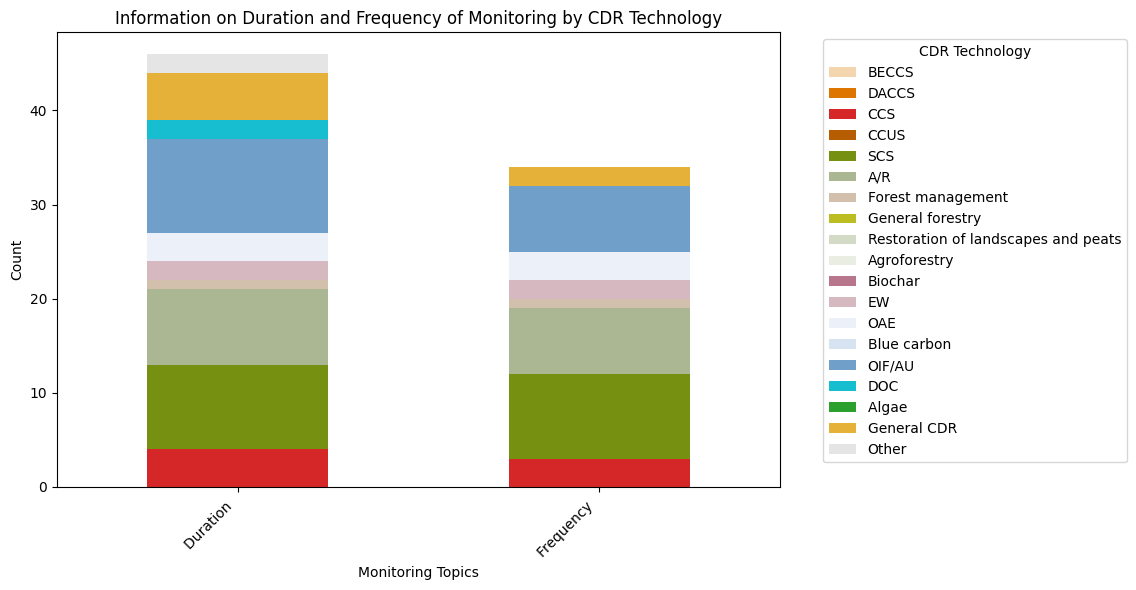

In [194]:
# Define the columns 
columns_monitoring = ["Duration ", "Frequency "]  # Ensure these names match exactly with your DataFrame

# Convert the columns to numeric, coercing errors
df_exploded[columns_monitoring] = df_exploded[columns_monitoring].apply(pd.to_numeric, errors='coerce')

desired_order_CDR = ['BECCS', 'DACCS', 'CCS', 'CCUS','SCS', 'A/R', 'Forest management', 'General forestry', 
                     'Restoration of landscapes and peats', 'Agroforestry', 'Biochar', 'EW', 'OAE', 'Blue carbon', 'OIF/AU',
                     'DOC', 'Algae ', 'General CDR', 'Other']

# Convert the Study location_continent column to a categorical type with the specified order
df_exploded['CDR_method'] = pd.Categorical(
    df_exploded['CDR_method'],
    categories=desired_order_CDR,
    ordered=True
)

# Melt the DataFrame to have 'CDR_method' and 'Topic' in long format
melted_df = df_exploded.melt(id_vars=['CDR_method'], value_vars=columns_monitoring, var_name='Topic', value_name='Value')

# Filter to keep only the rows where Value is 1 (indicating presence of the topic)
melted_df = melted_df[melted_df['Value'] == 1]

# Create a count of publications per topic and CDR_method
count_df = melted_df.groupby(['Topic', 'CDR_method'], observed=False).size().unstack(fill_value=0)

# Create a stacked bar plot
count_df.plot(kind='bar', stacked=True, figsize=(8, 6), width=0.5, color=custom_colors_CDR_method)  # Use a color map of your choice

# Add titles and labels
plt.title('Information on Duration and Frequency of Monitoring by CDR Technology')
plt.ylabel('Count')
plt.xlabel('Monitoring Topics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='CDR Technology', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.show()

In [195]:
# why are there ~10 appearances of OIF if there are only 5 documents discussing OIF?

In [196]:
# approach to fix this: Using data set that only exploded CDR technologies, not MRV topics --> do we have to fix other parts of the analysis?

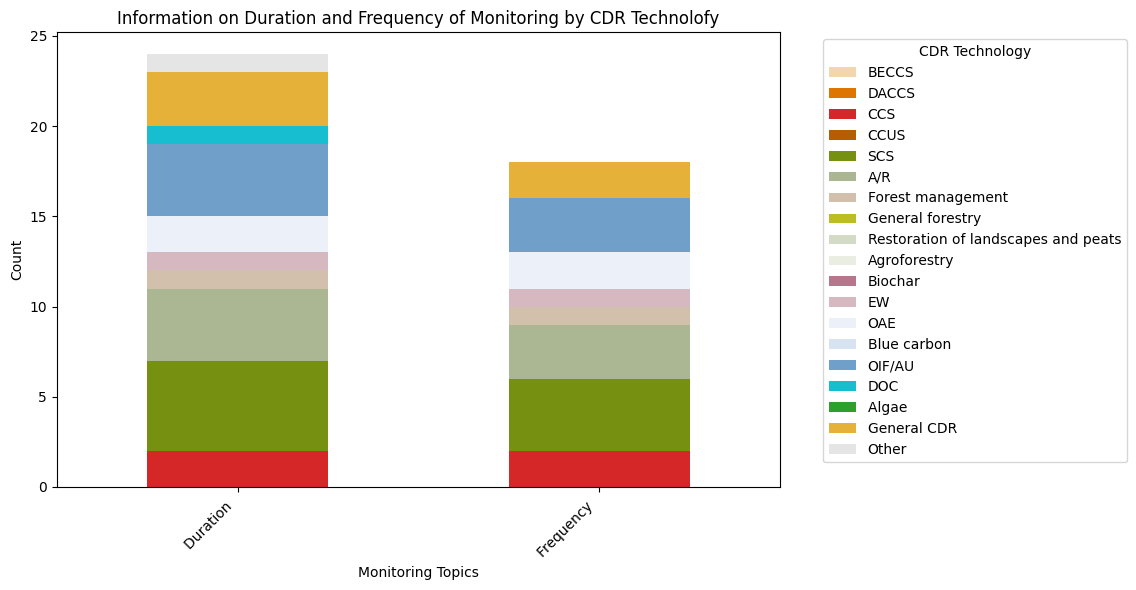

In [197]:
# Define the columns 
columns_monitoring = ["Duration ", "Frequency "]  # Ensure these names match exactly with your DataFrame

# Convert the columns to numeric, coercing errors
df_CDRexplode[columns_monitoring] = df_CDRexplode[columns_monitoring].apply(pd.to_numeric, errors='coerce')

desired_order_CDR = ['BECCS', 'DACCS', 'CCS', 'CCUS','SCS', 'A/R', 'Forest management', 'General forestry', 
                     'Restoration of landscapes and peats', 'Agroforestry', 'Biochar', 'EW', 'OAE', 'Blue carbon', 'OIF/AU',
                     'DOC', 'Algae ', 'General CDR', 'Other']

# Convert the Study location_continent column to a categorical type with the specified order
df_CDRexplode['CDR_method'] = pd.Categorical(
    df_CDRexplode['CDR_method'],
    categories=desired_order_CDR,
    ordered=True
)

# Melt the DataFrame to have 'CDR_method' and 'Topic' in long format
melted_df = df_CDRexplode.melt(id_vars=['CDR_method'], value_vars=columns_monitoring, var_name='Topic', value_name='Value')

# Filter to keep only the rows where Value is 1 (indicating presence of the topic)
melted_df = melted_df[melted_df['Value'] == 1]

# Create a count of publications per topic and CDR_method
count_df = melted_df.groupby(['Topic', 'CDR_method'], observed=False).size().unstack(fill_value=0)

# Create a stacked bar plot
count_df.plot(kind='bar', stacked=True, figsize=(8, 6), width=0.5, color=custom_colors_CDR_method)  # Use a color map of your choice

# Add titles and labels
plt.title('Information on Duration and Frequency of Monitoring by CDR Technolofy')
plt.ylabel('Count')
plt.xlabel('Monitoring Topics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='CDR Technology', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.show()

In [198]:
# Define the columns 
columns_monitoring = ["Duration ", "Frequency "]  # Ensure these names match exactly with your DataFrame

# Convert the columns to numeric, coercing errors
df_CDRexplode[columns_monitoring] = df_CDRexplode[columns_monitoring].apply(pd.to_numeric, errors='coerce')

# Melt the DataFrame to have 'CDR_method' and 'Topic' in long format
melted_df = df_CDRexplode.melt(id_vars=['CDR_group'], value_vars=columns_monitoring, var_name='Topic', value_name='Value')

# Filter to keep only the rows where Value is 1 (indicating presence of the topic)
melted_df = melted_df[melted_df['Value'] == 1]

# Create a count of publications per topic and CDR_method
count_df = melted_df.groupby(['Topic', 'CDR_group'], observed=False).size().unstack(fill_value=0)

# Create a stacked bar plot
count_df.plot(kind='bar', stacked=True, figsize=(8, 6), width=0.5, color=cdr_group_colors)  # Use a color map of your choice

# Add titles and labels
plt.title('Information on Duration and Frequency of Monitoring by grouped CDR Technology')
plt.ylabel('Count')
plt.xlabel('Monitoring Topics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Grouped CDR Technology', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.show()

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['CDR_group']"

##### Percentage (error)

In [199]:
# Define the columns
columns_monitoring = ["Duration ", "Frequency "]

# Convert the columns to numeric 
df_CDRexplode[columns_monitoring] = df_CDRexplode[columns_monitoring].apply(pd.to_numeric, errors='coerce')

# Melt the DataFrame to have 'CDR_method' and 'Topic' in long format
melted_df = df_CDRexplode.melt(id_vars=['CDR_group'], value_vars=columns_monitoring, var_name='Topic', value_name='Value')

# Count how many publications mention each topic (sum the values for each column)
topic_monitoring = df_CDRexplode[columns_monitoring].sum()

# Calculate the total number of publications (this assumes you have a specific column that indicates publications)
total_publications = df_included['Publication ID'].nunique()  # or use another column for total count if needed

# Calculate the percentage for each topic
monitoring_percentage = (topic_monitoring / total_publications) * 100  # multiply by 100 to get percentage

# Create a bar plot to visualize the counts
plt.figure(figsize=(10, 6))
bars = plt.bar(monitoring_percentage['Topic'], monitoring_percentage['Percentage'], color='skyblue')
plt.title('Percentage of Publications Covering Quality Topics')
plt.ylabel('Share of Publications (%)')
plt.ylim(0, 100)
plt.xlabel('Topics')
plt.xticks(rotation=45, ha='right')

# Add percentage labels at the end of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['CDR_group']"

##### What does the quantitative data in the Frequency & Duration section look like? (error)

In [200]:
# Define the columns 
columns_monitoring = ["Duration text", "Frequency text"] 

df_CDRexplode[['Duration text', 'Frequency text']] = df_CDRexplode[['Duration text', 'Frequency text']].astype(str)

# Filter the rows where both columns don't have "0" simultaneously
df_CDRexplode_filtered = df_CDRexplode[~((df_CDRexplode['Duration text'] == '0') & (df_CDRexplode['Frequency text'] == '0'))]

#df_CDRexplode_filtered

In [201]:
# Filter to keep only relevant columns
df_CDRexplode_filtered = df_CDRexplode[['CDR_group', 'Duration text', 'Frequency text']]

# Filter out rows where both 'Duration text' and 'Frequency text' are '0'
df_CDRexplode_filtered = df_CDRexplode_filtered[
    ~((df_CDRexplode_filtered['Duration text'] == '0') & (df_CDRexplode_filtered['Frequency text'] == '0'))
]

# Replace any 'nan' with an empty string if needed
df_CDRexplode_filtered.fillna('', inplace=True)

KeyError: "['CDR_group'] not in index"

C:\Users\chris\AppData\Local\Temp\ipykernel_6844\3706738882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_CDRexplode_filtered.replace('0', 'no information', inplace=True)


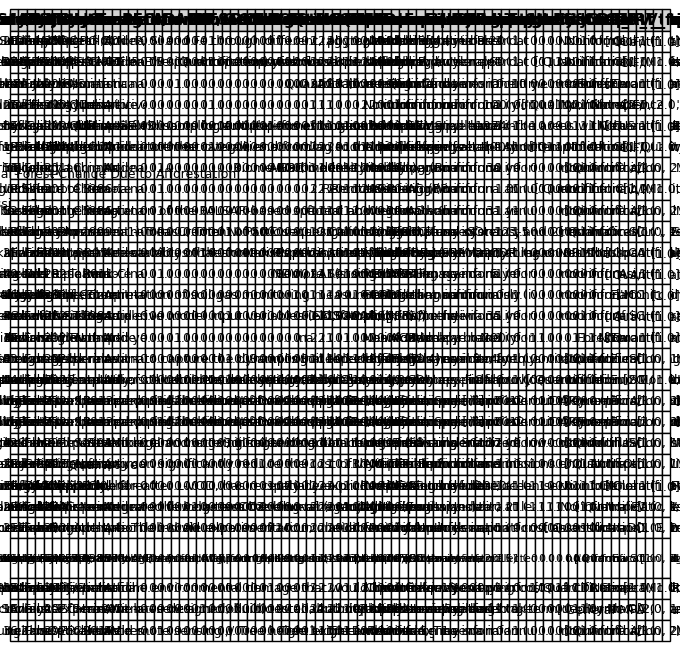

In [202]:
# Replace 0 with 'no information' in the DataFrame
df_CDRexplode_filtered.replace('0', 'no information', inplace=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(16, 8))  # Increase figure size for better readability

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=df_CDRexplode_filtered.values,
                 colLabels=df_CDRexplode_filtered.columns,
                 cellLoc='center',
                 loc='center')

# Adjust table settings for readability
table.auto_set_font_size(False)
table.set_fontsize(9) 
table.scale(2, 2) 

# Customize the header (light grey fill and large font)
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_fontsize(11) 
        cell.set_text_props(weight='bold')  
        cell.set_facecolor('#D3D3D3') 

# Customize the header (light grey fill and large font)
for (i, j), cell in table.get_celld().items():
    if i == 25:  # Header row
        cell.set_fontsize(8) 
        cell.set_height(0.1)

# Set tight layout to prevent clipping
plt.tight_layout()

# Show the table
plt.show()

### 7 MRV topic: Uncertainties

In [ ]:
# Define the columns 
columns_uncertainty = ["sources of uncertainty", "uncertainty management"]  # Ensure these names match exactly with your DataFrame

#### Figure: Uncertainty and Uncertainty Management by CDR Technology

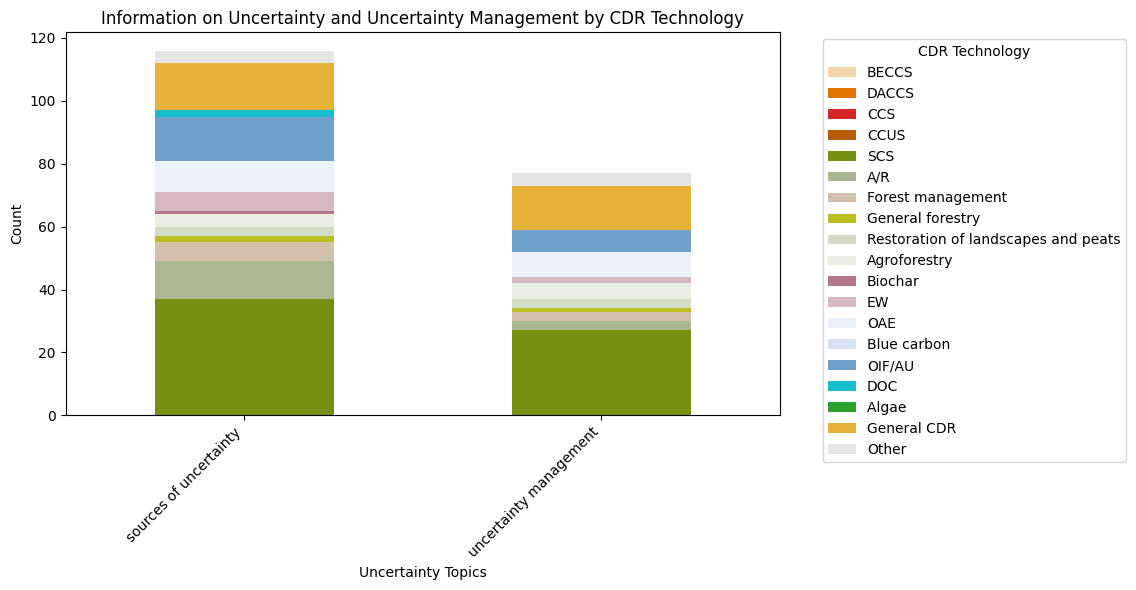

In [213]:
# Convert the columns to numeric, coercing errors
df_exploded[columns_uncertainty] = df_exploded[columns_uncertainty].apply(pd.to_numeric, errors='coerce')

desired_order_CDR = ['BECCS', 'DACCS', 'CCS', 'CCUS','SCS', 'A/R', 'Forest management', 'General forestry', 
                     'Restoration of landscapes and peats', 'Agroforestry', 'Biochar', 'EW', 'OAE', 'Blue carbon', 'OIF/AU',
                     'DOC', 'Algae ', 'General CDR', 'Other']

# Convert the Study location_continent column to a categorical type with the specified order
df_exploded['CDR_method'] = pd.Categorical(
    df_exploded['CDR_method'],
    categories=desired_order_CDR,
    ordered=True
)

# Melt the DataFrame to have 'CDR_method' and 'Topic' in long format
melted_df = df_exploded.melt(id_vars=['CDR_method'], value_vars=columns_uncertainty, var_name='Topic', value_name='Value')

# Filter to keep only the rows where Value is 1 (indicating presence of the topic)
melted_df = melted_df[melted_df['Value'] == 1]

# Create a count of publications per topic and CDR_method
count_df = melted_df.groupby(['Topic', 'CDR_method'], observed=False).size().unstack(fill_value=0)

# Create a stacked bar plot
count_df.plot(kind='bar', stacked=True, figsize=(8, 6), width=0.5, color=custom_colors_CDR_method)  # Use a color map of your choice

# Add titles and labels
plt.title('Information on Uncertainty and Uncertainty Management by CDR Technology')
plt.ylabel('Count')
plt.xlabel('Uncertainty Topics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='CDR Technology', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.show()

#### Figure: Uncertainty and Uncertainty Management by CDR groups

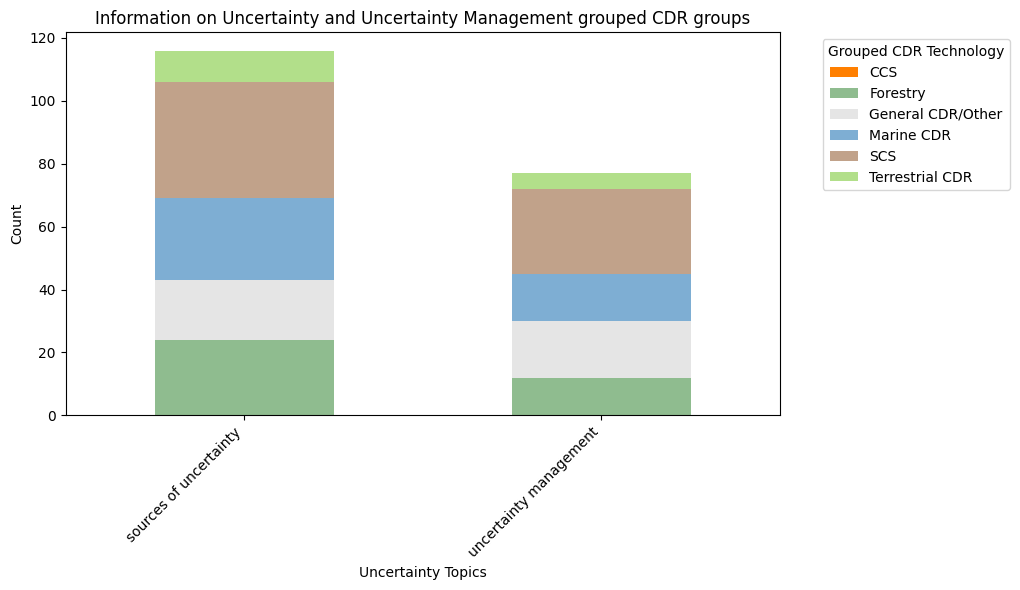

In [212]:
# Convert the columns to numeric, coercing errors
df_exploded[columns_uncertainty] = df_exploded[columns_uncertainty].apply(pd.to_numeric, errors='coerce')

# Convert the Study location_continent column to a categorical type with the specified order
df_exploded['CDR_group'] = pd.Categorical(
    df_exploded['CDR_group'],
    ordered=True
)

# Melt the DataFrame to have 'CDR_method' and 'Topic' in long format
melted_df = df_exploded.melt(id_vars=['CDR_group'], value_vars=columns_uncertainty, var_name='Topic', value_name='Value')

# Filter to keep only the rows where Value is 1 (indicating presence of the topic)
melted_df = melted_df[melted_df['Value'] == 1]

# Create a count of publications per topic and CDR_method
count_df = melted_df.groupby(['Topic', 'CDR_group'], observed=False).size().unstack(fill_value=0)

# Create a stacked bar plot
count_df.plot(kind='bar', stacked=True, figsize=(8, 6), width=0.5, color=cdr_group_colors)  # Use a color map of your choice

# Add titles and labels
plt.title('Information on Uncertainty and Uncertainty Management grouped CDR groups')
plt.ylabel('Count')
plt.xlabel('Uncertainty Topics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Grouped CDR Technology', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.show()

#### Figure: Information on Uncertainty for each CDR method

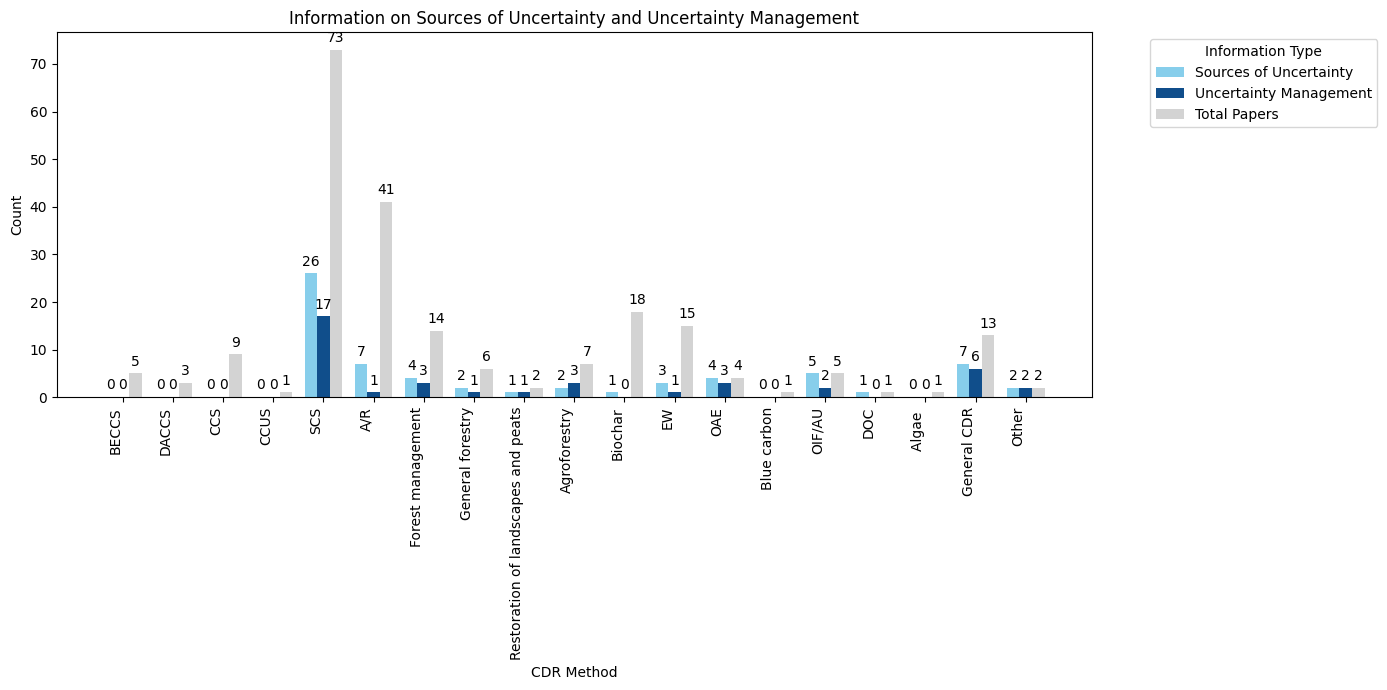

In [216]:
# Calculate the total number of publications per CDR technology
total_per_tech = df_CDRexplode.groupby("CDR_method", observed=False)["Publication ID"].nunique()

# Calculate the number of publications that contain information on each uncertainty topic
uncertainty_counts = df_CDRexplode[df_CDRexplode[columns_uncertainty].notna().any(axis=1)].groupby("CDR_method", observed=False)[columns_uncertainty].sum()

# Combine both uncertainty counts and the total counts
uncertainty_df = pd.concat([uncertainty_counts, total_per_tech], axis=1, sort=False)
uncertainty_df.columns = columns_uncertainty + ["Total Papers"]

# Set up for grouped bar plot
bar_width = 0.25  # Width of each bar
x = np.arange(len(uncertainty_df.index))  # Define positions for CDR methods

# Plot the bars for each topic separately
fig, ax = plt.subplots(figsize=(14, 7))

# Bar positions for each category
bar1 = ax.bar(x - bar_width, uncertainty_df["sources of uncertainty"], width=bar_width, color='skyblue', label='Sources of Uncertainty')
bar2 = ax.bar(x, uncertainty_df["uncertainty management"], width=bar_width, color='#104E8B', label='Uncertainty Management')
bar3 = ax.bar(x + bar_width, uncertainty_df["Total Papers"], width=bar_width, color='lightgray', label='Total Papers')

# Add data labels to the bars
for bar in [bar1, bar2, bar3]:
    for rect in bar:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 1, f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(uncertainty_df.index, rotation=90, ha='right')

# Set plot labels and title
ax.set_xlabel('CDR Method')
ax.set_ylabel('Count')
ax.set_title('Information on Sources of Uncertainty and Uncertainty Management')
plt.legend(title='Information Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()